In [1]:
# 1. Make a binary classification dataset with Scikit-Learn's make_moons() function

In [2]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import sklearn
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

# Create moons
X, y = make_moons(n_samples,
                  shuffle=True,
                  noise=None,
                  random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.00872719  0.36817352]
 [ 0.921384   -0.49690497]
 [ 0.94022577 -0.49821192]
 [ 0.46587532 -0.34540571]
 [-0.85041204  0.52611726]]
First 5 samples of y:
 [1 1 1 1 0]


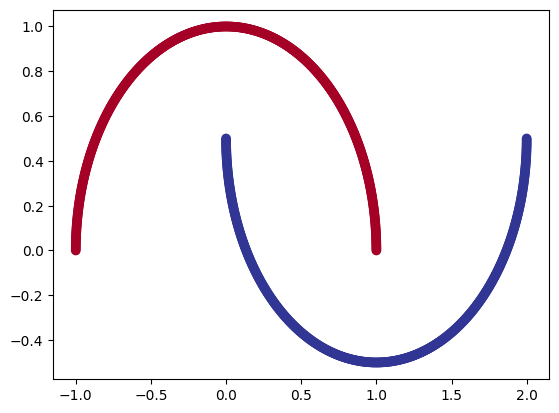

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [7]:
# Turn data into tensors and create train and test splits
import torch
torch.__version__

'2.3.0+cu121'

In [8]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [13]:
# 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [14]:
# Building a model with non-linearity

# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=20)
    self.layer_3 = nn.Linear(in_features=20, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear acivation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = CircleModelV2().to(device)
model_0

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
# 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [16]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [17]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [18]:
# 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 500

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.6887, Acc: 59.25% | Test Loss: 0.6872, Test Acc: 62.50%
Epoch: 10 | Loss: 0.6655, Acc: 81.25% | Test Loss: 0.6657, Test Acc: 82.00%
Epoch: 20 | Loss: 0.6370, Acc: 82.75% | Test Loss: 0.6387, Test Acc: 79.50%
Epoch: 30 | Loss: 0.5986, Acc: 83.12% | Test Loss: 0.6021, Test Acc: 78.50%
Epoch: 40 | Loss: 0.5492, Acc: 83.25% | Test Loss: 0.5556, Test Acc: 78.00%
Epoch: 50 | Loss: 0.4906, Acc: 83.25% | Test Loss: 0.5006, Test Acc: 79.00%
Epoch: 60 | Loss: 0.4305, Acc: 83.50% | Test Loss: 0.4440, Test Acc: 81.00%
Epoch: 70 | Loss: 0.3785, Acc: 84.38% | Test Loss: 0.3947, Test Acc: 81.50%
Epoch: 80 | Loss: 0.3381, Acc: 84.75% | Test Loss: 0.3552, Test Acc: 85.00%
Epoch: 90 | Loss: 0.3080, Acc: 85.25% | Test Loss: 0.3245, Test Acc: 87.00%
Epoch: 100 | Loss: 0.2854, Acc: 86.25% | Test Loss: 0.3004, Test Acc: 87.50%
Epoch: 110 | Loss: 0.2680, Acc: 87.25% | Test Loss: 0.2812, Test Acc: 88.00%
Epoch: 120 | Loss: 0.2544, Acc: 88.12% | Test Loss: 0.2657, Test Acc: 88.00%
Epoch: 130

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [20]:
# 5. Make predictions with your trained model and plot them using the

In [21]:
# Make predictions
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

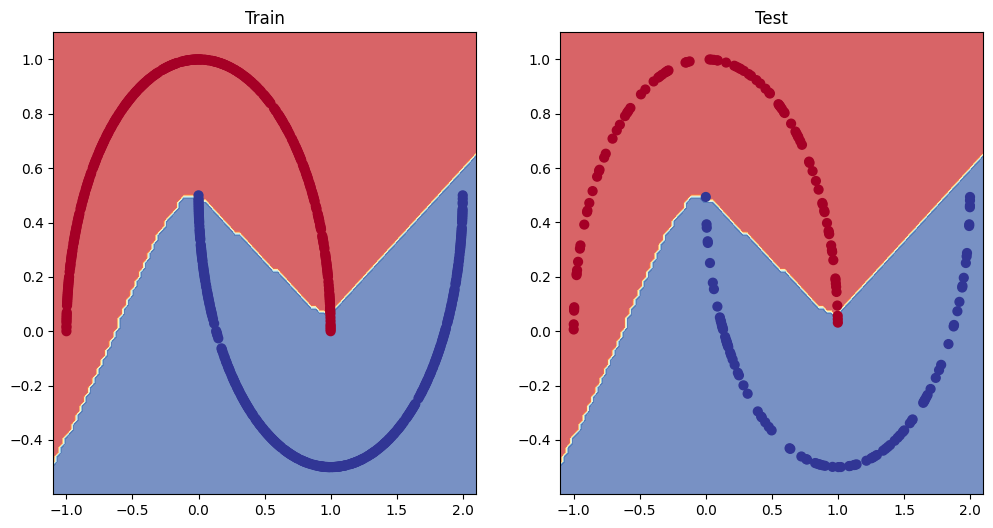

In [22]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [23]:
# 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [24]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

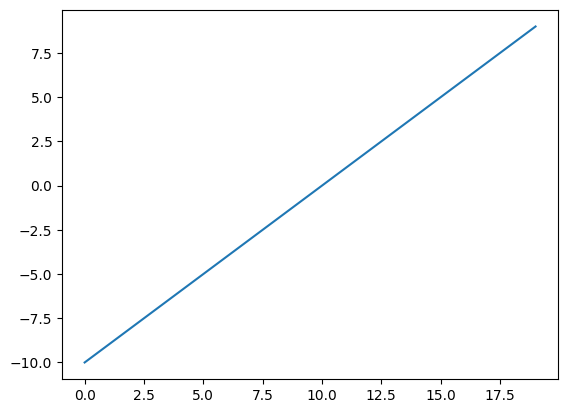

In [25]:
# Visualize the tensor
plt.plot(A)

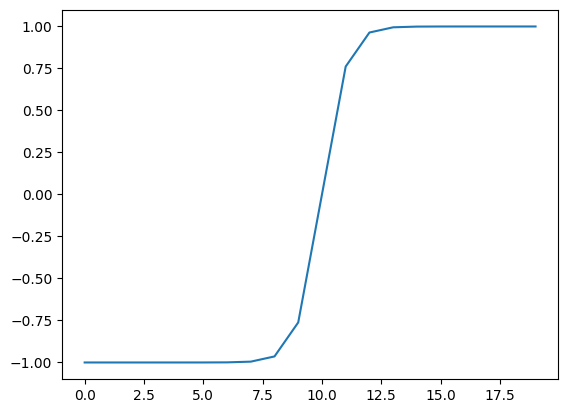

In [26]:
plt.plot(torch.tanh(A))

In [27]:
# Create an instance of the Tanh activation function
tanh = torch.nn.Tanh()

# Pass the tensor through the Tanh activation function
output = tanh(A)

# Print the output tensor
print(output)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])


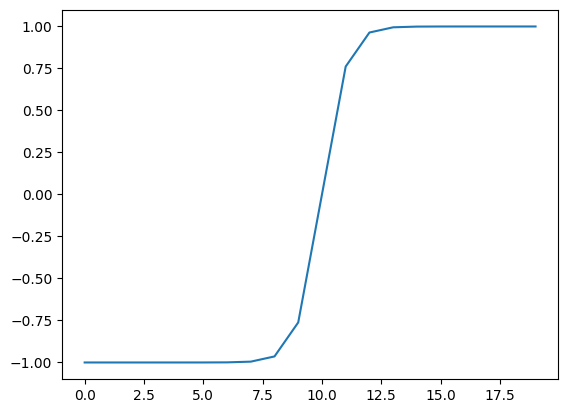

In [28]:
plt.plot(output)

In [29]:
def tanh(z):
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

tanh(A)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

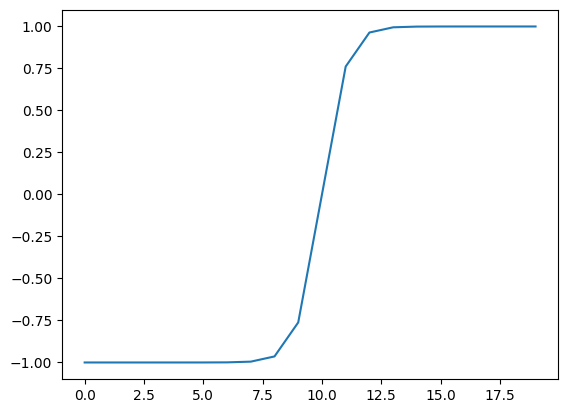

In [30]:
# Plot Tanh activation function
plt.plot(tanh(A))

In [31]:
# 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

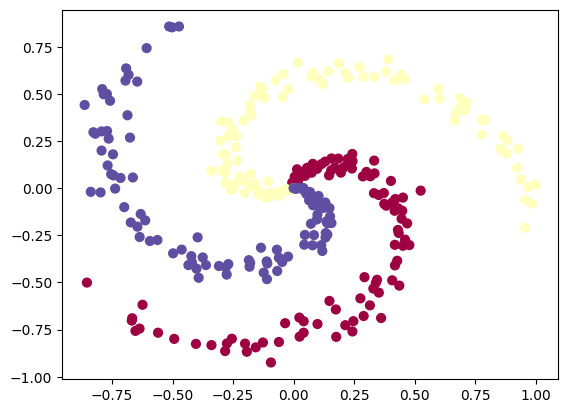

In [32]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [33]:
# Turn data into tensors
X_spiral = torch.from_numpy(X).type(torch.float)
y_spiral = torch.from_numpy(y).type(torch.LongTensor)

# Split into train and test
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral,
                                                                                y_spiral,
                                                                                test_size=0.2,
                                                                                random_state=42)

In [34]:
# Building a multi-class classification model in PyTorch

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [35]:
# Build a multi-class classification model
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model

    Args:
    input_features (int): Number of input features to the model
    output_features (int): Number of outputs features (number of output classes)
    hidden_units (int): Number of hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of SpiralModel and send it to the target device
model_1 = SpiralModel(input_features=2,
                      output_features=3,
                      hidden_units=8).to(device)

model_1

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [36]:
X_spiral_train.shape, y_spiral_train.shape[:5]

(torch.Size([240, 2]), torch.Size([240]))

In [37]:
torch.unique(y_spiral_train)

tensor([0, 1, 2])

In [38]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)

In [39]:
# Getting prediction probabilities for a multi-class PyTorch model

In [40]:
# Let's get some raw outputs of our model (logits)

model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_spiral_test).to(device)

y_logits[:10]

tensor([[-0.0736, -0.3837, -0.2466],
        [-0.0602, -0.3299, -0.2105],
        [-0.0882, -0.4148, -0.2933],
        [-0.0747, -0.3885, -0.2543],
        [-0.0532, -0.3456, -0.2045],
        [-0.0708, -0.3578, -0.2306],
        [-0.2107, -0.3731, -0.4389],
        [-0.0634, -0.3683, -0.2346],
        [-0.0726, -0.3842, -0.2495],
        [-0.1836, -0.3811, -0.4060]])

In [41]:
y_spiral_test[:10]

tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1])

In [42]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0736, -0.3837, -0.2466],
        [-0.0602, -0.3299, -0.2105],
        [-0.0882, -0.4148, -0.2933],
        [-0.0747, -0.3885, -0.2543],
        [-0.0532, -0.3456, -0.2045]])
tensor([[0.3884, 0.2849, 0.3267],
        [0.3811, 0.2910, 0.3279],
        [0.3943, 0.2845, 0.3212],
        [0.3897, 0.2847, 0.3256],
        [0.3837, 0.2864, 0.3298]])


In [43]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [44]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
# Creating a training loop and testing loop for a multi-class PyTorch model

In [46]:
print(test_logits.shape)  # Should be [batch_size, num_classes]
print(y_test.shape)       # Should be [batch_size]

torch.Size([200])
torch.Size([200])


In [47]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spital_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

# Loop through data
for epoch in range(epochs):
  ## Training
  model_1.train()

  y_logits = model_1(X_spiral_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_spiral_train)
  acc = accuracy_fn(y_true=y_spiral_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_spiral_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_spiral_test)
    test_acc = accuracy_fn(y_true=y_spiral_test,
                           y_pred=test_preds)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss 1.1030, Acc: 32.50% | Test loss: 1.0743, Test acc: 45.00%
Epoch: 10 | Loss 0.6521, Acc: 71.25% | Test loss: 0.6675, Test acc: 71.67%
Epoch: 20 | Loss 0.2440, Acc: 92.92% | Test loss: 0.2334, Test acc: 91.67%
Epoch: 30 | Loss 0.0936, Acc: 97.08% | Test loss: 0.0856, Test acc: 100.00%
Epoch: 40 | Loss 0.0515, Acc: 98.33% | Test loss: 0.0288, Test acc: 100.00%
Epoch: 50 | Loss 0.0374, Acc: 98.75% | Test loss: 0.0147, Test acc: 100.00%
Epoch: 60 | Loss 0.0305, Acc: 99.17% | Test loss: 0.0097, Test acc: 100.00%
Epoch: 70 | Loss 0.0266, Acc: 99.17% | Test loss: 0.0079, Test acc: 100.00%
Epoch: 80 | Loss 0.0247, Acc: 99.17% | Test loss: 0.0059, Test acc: 100.00%
Epoch: 90 | Loss 0.0228, Acc: 99.17% | Test loss: 0.0067, Test acc: 100.00%


In [49]:
# Make predictions
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_spiral_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  0.5724,  -3.9336,   3.4095],
        [-16.6768,   0.8706,  12.3370],
        [  4.0142,   6.9493, -15.0457],
        [  7.0618,  -3.2187,  -4.0634],
        [ -8.5436,  -1.2942,   8.8831],
        [ -8.7050,  -1.6597,   9.3991],
        [ -3.6886,  13.0511, -25.3213],
        [ -3.0331,   4.1516,  -4.1063],
        [  3.8088,  -2.5374,  -1.7820],
        [  2.2101,  15.5610, -32.2952]])

In [51]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[5.5323e-02, 6.1087e-04, 9.4407e-01],
        [2.5087e-13, 1.0476e-05, 9.9999e-01],
        [5.0445e-02, 9.4956e-01, 2.6620e-10],
        [9.9995e-01, 3.4293e-05, 1.4735e-05],
        [2.7017e-08, 3.8023e-05, 9.9996e-01],
        [1.3724e-08, 1.5747e-05, 9.9998e-01],
        [5.3708e-08, 1.0000e+00, 2.1632e-17],
        [7.5734e-04, 9.9898e-01, 2.5895e-04],
        [9.9454e-01, 1.7438e-03, 3.7115e-03],
        [1.5914e-06, 1.0000e+00, 1.6455e-21]])

In [52]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1])

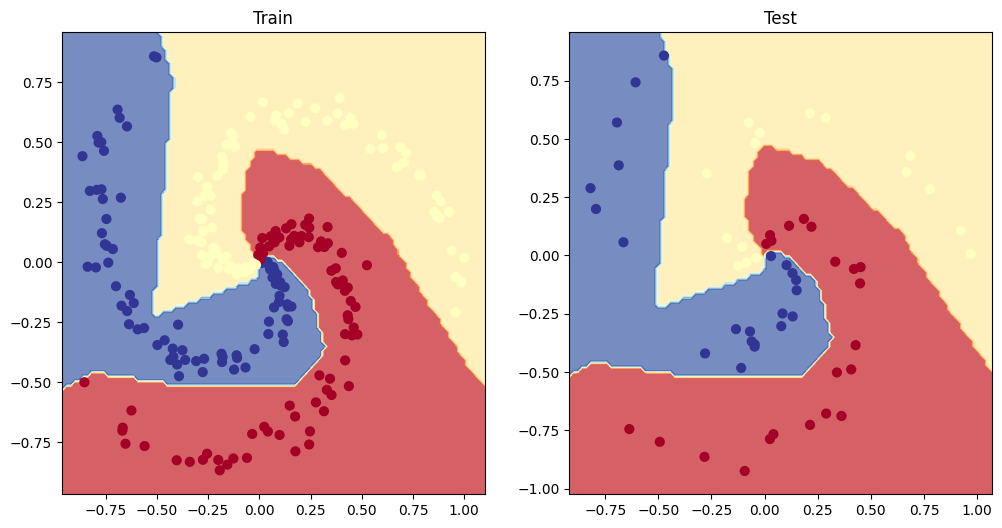

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_spiral_train, y_spiral_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_spiral_test, y_spiral_test)